In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import sqlite3
import json

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## read in data from local json database
read in data 

In [4]:
df = pd.read_json('../ML_data_DJF.json')

## clean data

In [5]:
from datetime import datetime
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['新竹浮標','臺東外洋浮標','東沙島浮標','馬祖浮標']
stnlist=['臺東外洋浮標','東沙島浮標','馬祖浮標']

dataset = dataset[dataset['STN'].isin(stnlist)]
dataset = dataset.dropna()

In [6]:
dataset.isna().sum()

STN         0
ST          0
DATETIME    0
H           0
Temp        0
P           0
Vm          0
Vmsat       0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [7]:
dataset = dataset.dropna()
dataset.tail()

,STN,ST,DATETIME,H,Temp,P,Vm,Vmsat
877101,馬祖浮標,C6W08,2018-12-30 20:00:00,3.52,16.3,1030.6,14.0,16.348304
877107,馬祖浮標,C6W08,2018-12-31 02:00:00,2.73,16.1,1030.4,12.4,14.287296
877113,馬祖浮標,C6W08,2018-12-31 08:00:00,3.51,16.1,1032.7,12.9,14.614159
877119,馬祖浮標,C6W08,2018-12-31 14:00:00,3.10,15.5,1029.3,12.5,14.517667
877125,馬祖浮標,C6W08,2018-12-31 20:00:00,3.33,15.8,1031.2,12.9,13.381326


<Figure size 3200x1600 with 0 Axes>

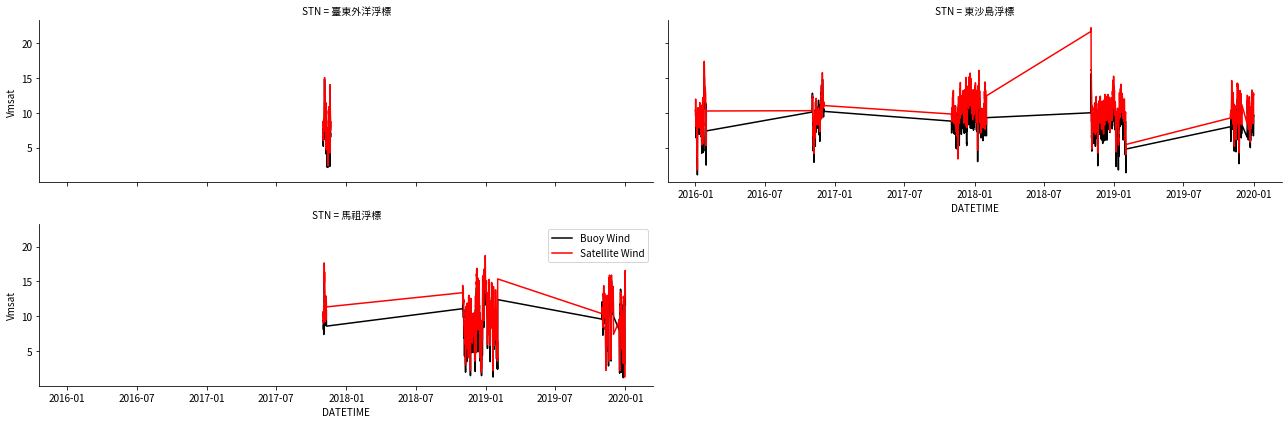

In [8]:
%matplotlib inline
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

In [9]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

154431    臺東外洋浮標
154437    臺東外洋浮標
154443    臺東外洋浮標
154449    臺東外洋浮標
154455    臺東外洋浮標
           ...  
877101      馬祖浮標
877107      馬祖浮標
877113      馬祖浮標
877119      馬祖浮標
877125      馬祖浮標
Name: STN, Length: 1685, dtype: object

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

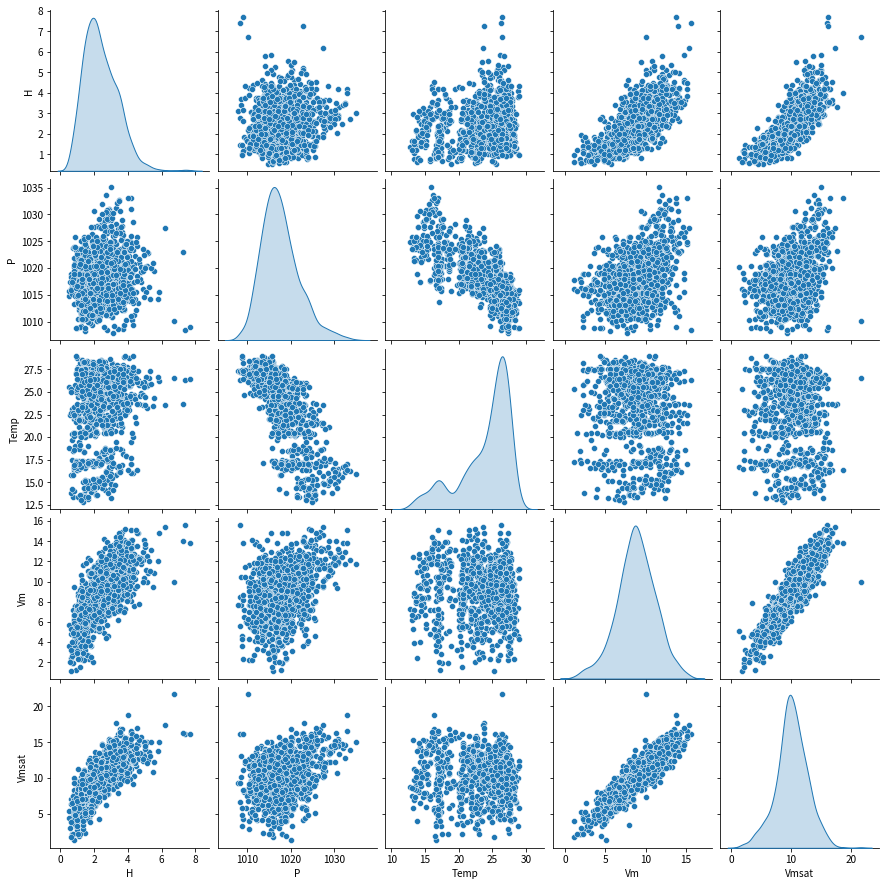

In [11]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
H,1348.0,2.412945,0.996230,0.560000,1.680000,2.25500,3.060000,7.680000
Temp,1348.0,23.958605,3.736029,12.800000,22.100000,25.40000,26.700000,29.000000
P,1348.0,1017.600964,4.366773,1007.900000,1014.575000,1017.10000,1020.000000,1035.200000
Vm,1348.0,8.823516,2.398936,1.100000,7.300000,8.80000,10.400000,15.600000
Vmsat,1348.0,10.139725,2.639663,1.293657,8.672546,10.14273,11.761087,21.665361


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
H,2.412945,0.996230
Temp,23.958605,3.736029
P,1017.600964,4.366773
Vm,8.823516,2.398936
Vmsat,10.139725,2.639663


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [15]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [16]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [17]:
print(normalizer.mean.numpy())

[  23.959 1017.601    8.824   10.14 ]


When the layer is called it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  25.8  1012.      8.3    10.18]]

Normalized: [[ 0.49 -1.28 -0.22  0.02]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `H` from `Vmsat`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `Vmsat`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [19]:
Vmsat = np.array(train_features['Vmsat'])

Vmsat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
Vmsat_normalizer.adapt(Vmsat)

Build the sequential model:

In [20]:
Vmsat_model = tf.keras.Sequential([
    Vmsat_normalizer,
    layers.Dense(units=1)
])

Vmsat_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `H` from `Vmsat`.

Run the untrained model on the first 10 Vmsat values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [21]:
Vmsat_model.predict(Vmsat[:10])

array([[-0.   ],
       [-0.043],
       [-0.01 ],
       [-0.026],
       [ 0.047],
       [ 0.07 ],
       [ 0.012],
       [ 0.031],
       [ 0.003],
       [-0.009]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [22]:
Vmsat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [23]:
%%time
history = Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 40.5 s, sys: 6min 9s, total: 6min 50s
Wall time: 26.5 s


Visualize the model's training progress using the stats stored in the `history` object.

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.506956,0.519543,95
96,0.505354,0.515104,96
97,0.501149,0.518920,97
98,0.507265,0.509620,98
99,0.505419,0.517009,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

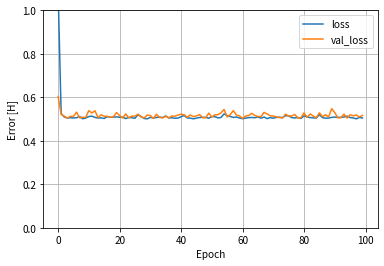

In [26]:
plot_loss(history)

Collect the results on the test set, for later:

In [27]:
test_results = {}

test_results['Vmsat_model'] = Vmsat_model.evaluate(
    test_features['Vmsat'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [28]:
x = tf.linspace(0.0, 20, 251)
y = Vmsat_model.predict(x)

In [29]:
def plot_Vmsat(x, y):
  plt.scatter(train_features['Vmsat'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vmsat')
  plt.ylabel('H')
  plt.legend()

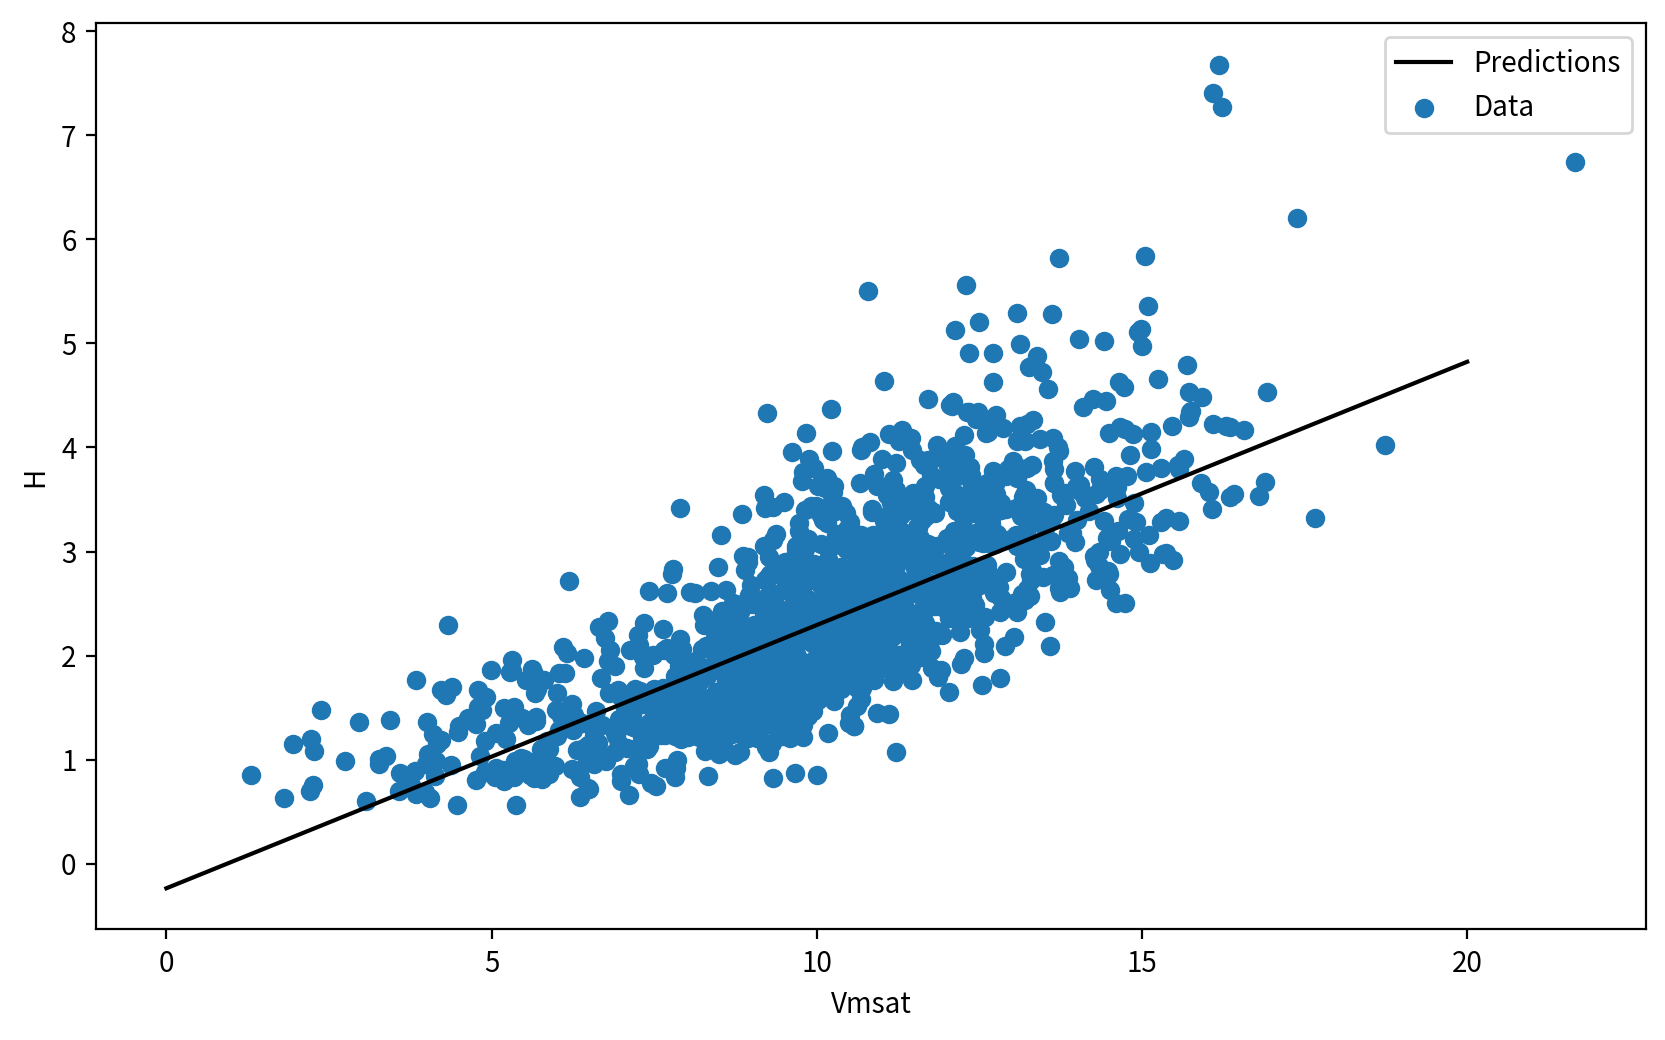

In [30]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [32]:
linear_model.predict(train_features[:10])

array([[ 0.355],
       [ 2.73 ],
       [ 1.233],
       [ 2.216],
       [-1.834],
       [-5.421],
       [-0.291],
       [-0.625],
       [ 0.668],
       [ 0.661]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(4,1)`.

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[0.976],
       [0.071],
       [0.229],
       [1.025]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `Vmsat` model:

In [34]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 36.8 s, sys: 5min 58s, total: 6min 35s
Wall time: 25.3 s


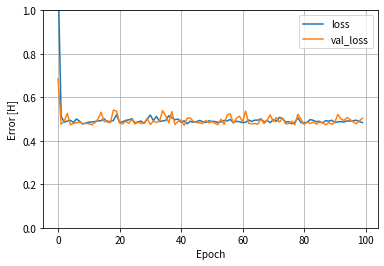

In [36]:
plot_loss(history)

In [37]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [38]:
x = tf.linspace(0.0, 50, 251)
y = linear_model.predict(pd.DataFrame(x))

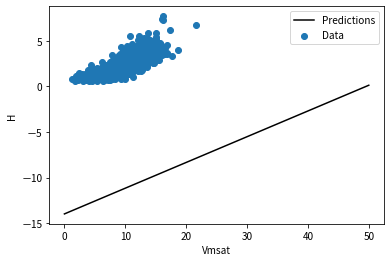

In [39]:
plot_Vmsat(x,y)

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.493667
linear_model,0.477027


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [41]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Vmsat"

In [42]:
dnn_Vmsat_model = build_and_compile_model(Vmsat_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [43]:
dnn_Vmsat_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [44]:
%%time
history = dnn_Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1min 3s, sys: 7min 49s, total: 8min 52s
Wall time: 27 s


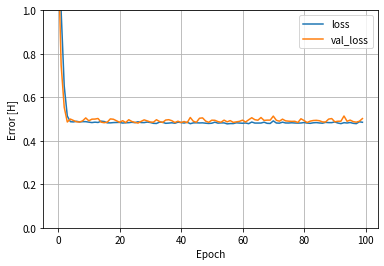

In [45]:
plot_loss(history)

In [46]:
x = tf.linspace(0.0, 20, 251)
y = dnn_Vmsat_model.predict(x)

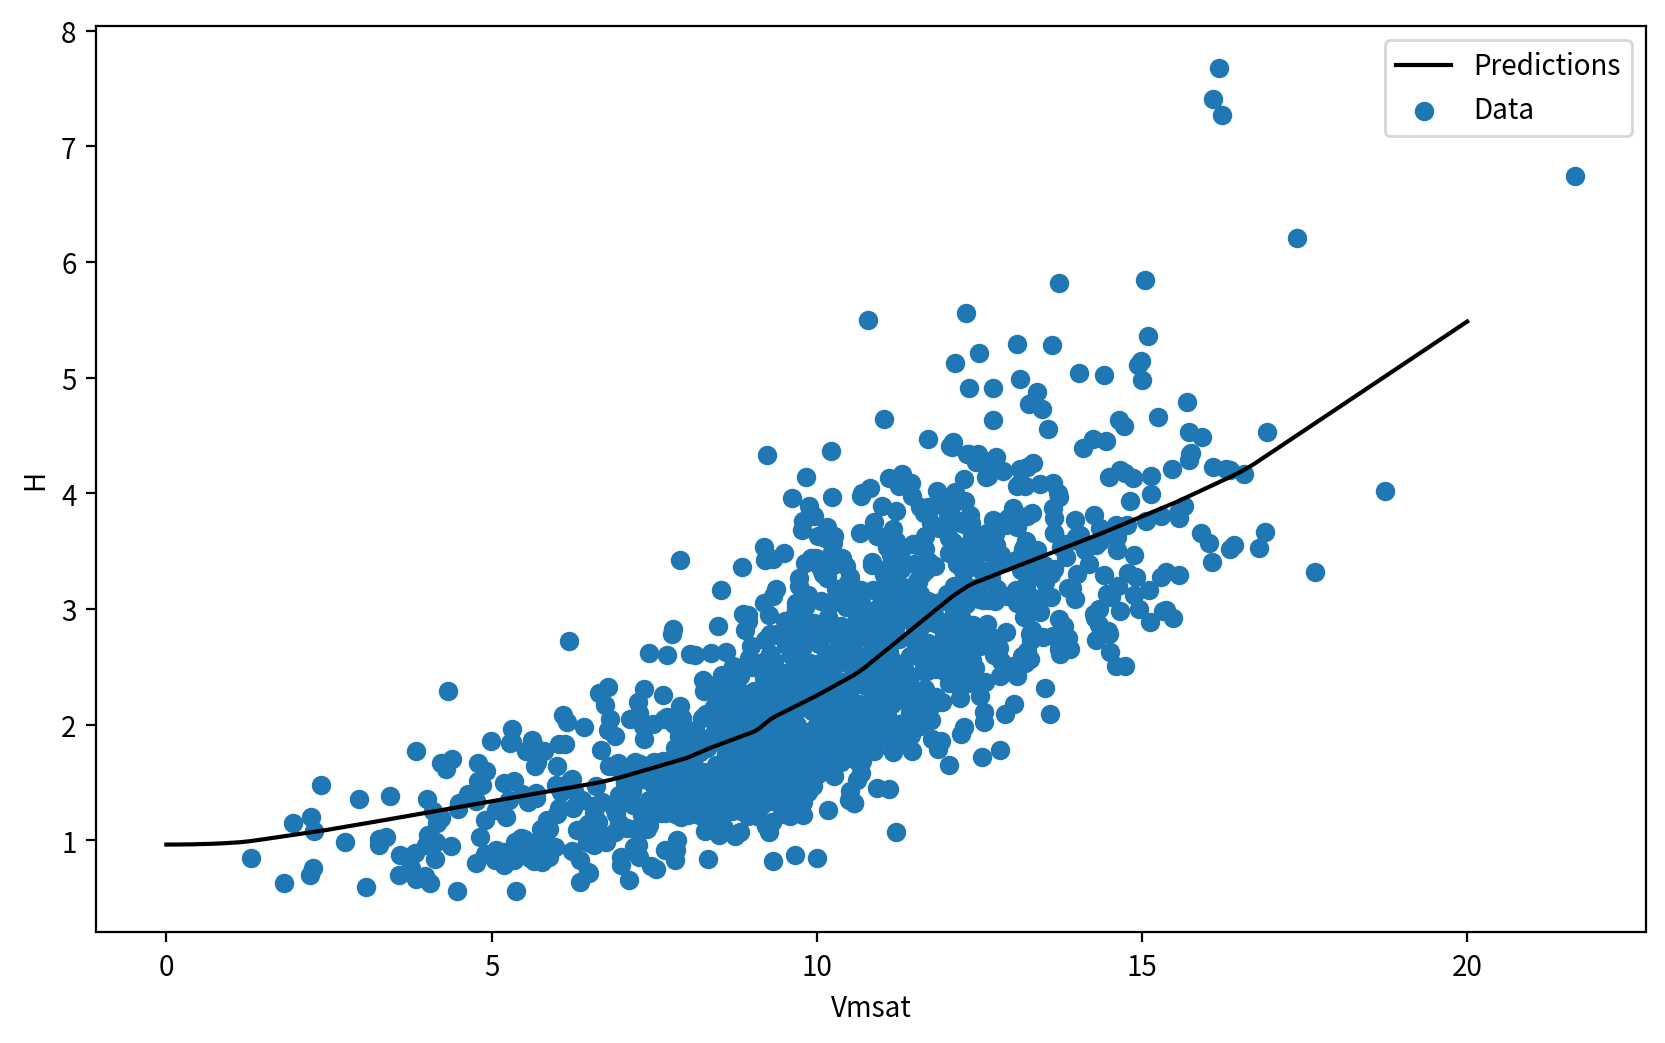

In [47]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

In [48]:
test_results['dnn_Vmsat_model'] = dnn_Vmsat_model.evaluate(
    test_features['Vmsat'], test_labels,
    verbose=0)

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.493667
linear_model,0.477027
dnn_Vmsat_model,0.486456


### Full model

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [51]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 53 s, sys: 7min 37s, total: 8min 30s
Wall time: 41.2 s


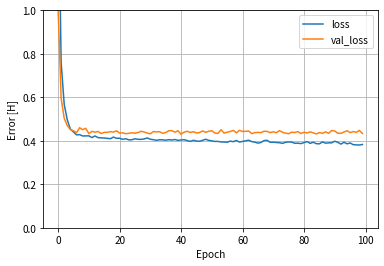

In [52]:
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

11/11 [==============================] - 0s 6ms/step - loss: 0.4040


In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.493667
linear_model,0.477027
dnn_Vmsat_model,0.486456
dnn_model,0.403960


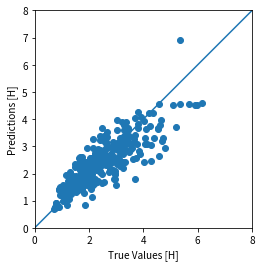

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

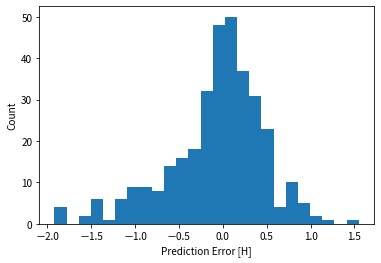

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

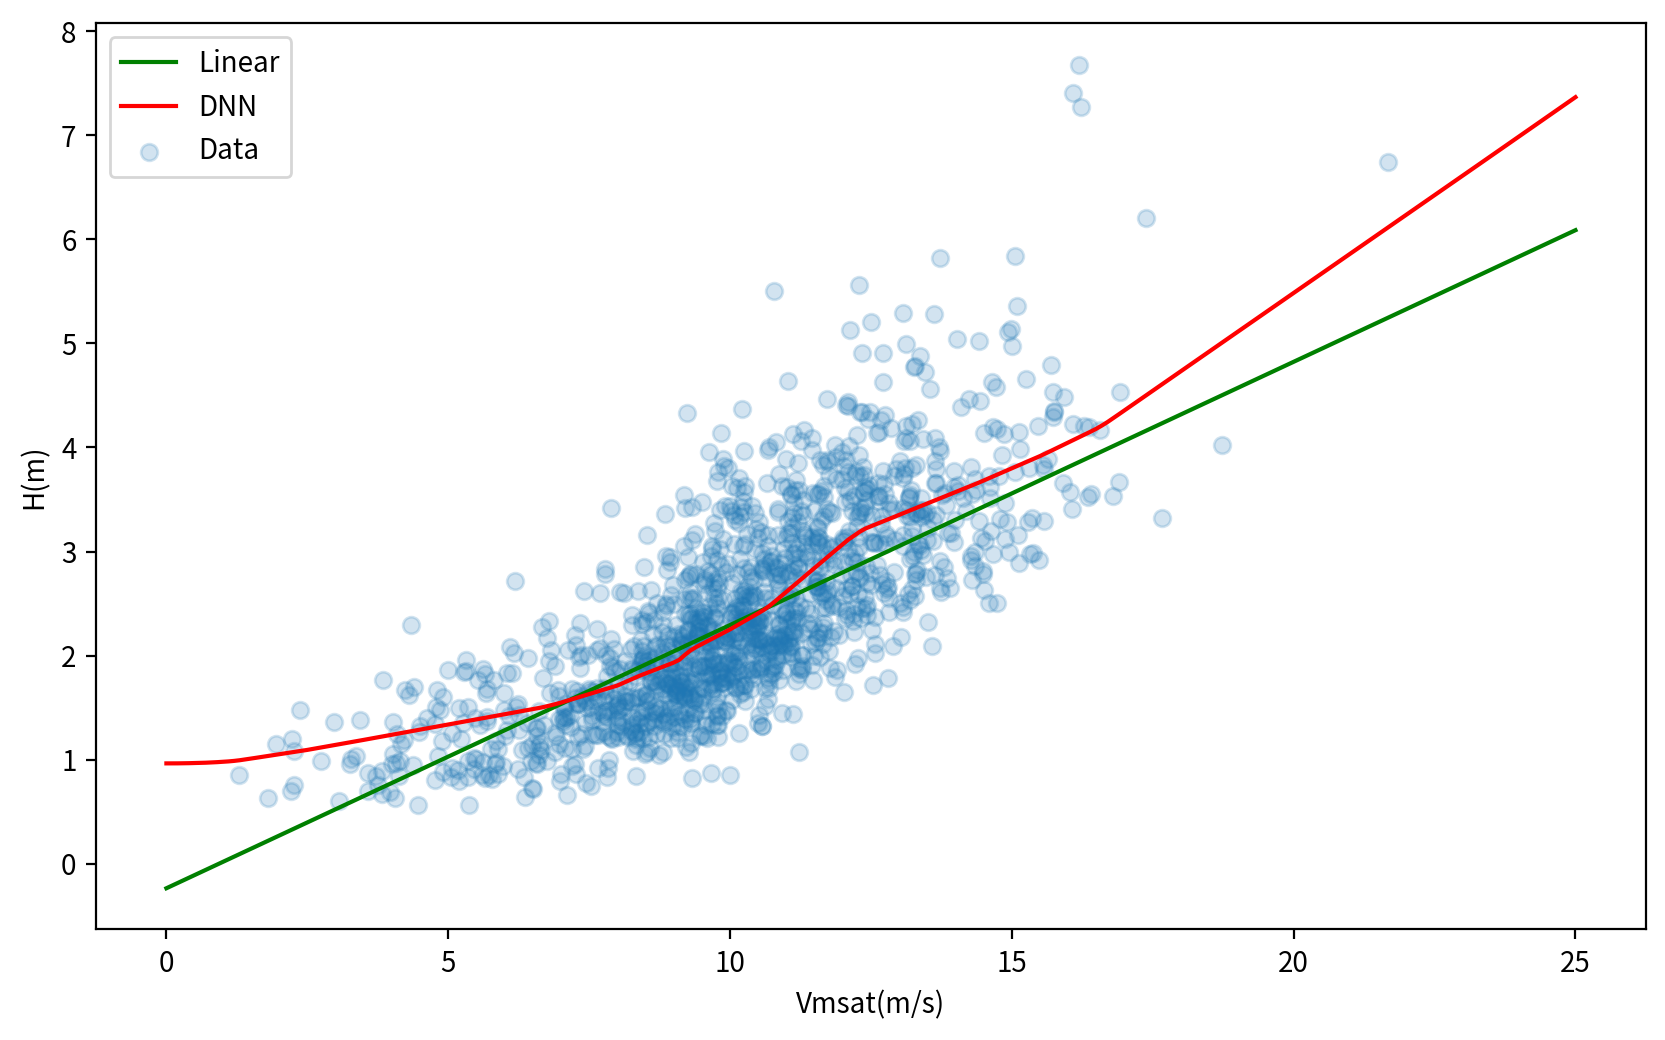

In [57]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
#y1 = dnn_model.predict(x)
y2 = dnn_Vmsat_model.predict(pd.DataFrame(x))
y4 = Vmsat_model.predict(pd.DataFrame(x))

plt.scatter(train_features['Vmsat'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.xlabel('Vmsat(m/s)')
plt.ylabel('H(m)')
plt.legend()

In [58]:
linear_model.save('saved_model/Vmsat_H_linear_model_DJF')
Vmsat_model.save(    'saved_model/Vmsat_H_Vm_model_DJF')
dnn_model.save(   'saved_model/Vmsat_H_dnn_model_DJF')
dnn_Vmsat_model.save('saved_model/Vmsat_H_dnn_Vm_model_DJF')

INFO:tensorflow:Assets written to: saved_model/Vmsat_H_linear_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_Vm_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_dnn_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_dnn_Vm_model_DJF/assets


## RNN 

In [59]:
def build_and_compile_model_RNN(Norm):
  model = keras.Sequential([
      Norm,
      layers.SimpleRNN(64,  unroll=False, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [60]:
def build_and_compile_model_LSTM(Norm):
  model = keras.Sequential([
      Norm,
      layers.LSTM(64, input_shape=(1,1), activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
Vmsat_normalizer = preprocessing.Normalization(input_shape=[1,1], axis=None)
Vmsat_normalizer.adapt(Vmsat)

In [62]:
rnn_Vmsat_model = build_and_compile_model_RNN(Vmsat_normalizer)
#rnn_Vmsat_model = build_and_compile_model_LSTM(Vmsat_normalizer)

In [63]:
rnn_Vmsat_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1, 1)              3         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [64]:
train_features['Vmsat'],train_labels

(154635    10.179573
 160236    14.978298
 772437    11.296713
 862898    13.071818
 869583     4.793984
             ...    
 773200    10.551093
 780292     7.080730
 862697     9.893351
 870354    11.531470
 780821    11.426239
 Name: Vmsat, Length: 1348, dtype: float64,
 154635    2.93
 160236    5.14
 772437    3.20
 862898    3.05
 869583    1.67
           ... 
 773200    1.93
 780292    1.33
 862697    1.75
 870354    2.71
 780821    2.41
 Name: H, Length: 1348, dtype: float64)

In [65]:
%%time
history = rnn_Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
34/34 [==============================] - 3s 50ms/step - loss: 2.3105 - val_loss: 1.8974
Epoch 2/100
34/34 [==============================] - 0s 13ms/step - loss: 1.8268 - val_loss: 1.5089
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 1.4825 - val_loss: 1.0776
Epoch 4/100
34/34 [==============================] - 1s 17ms/step - loss: 1.0256 - val_loss: 0.6555
Epoch 5/100
34/34 [==============================] - 0s 13ms/step - loss: 0.6281 - val_loss: 0.5364
Epoch 6/100
34/34 [==============================] - 1s 18ms/step - loss: 0.5659 - val_loss: 0.5085
Epoch 7/100
34/34 [==============================] - 0s 8ms/step - loss: 0.4938 - val_loss: 0.4965
Epoch 8/100
34/34 [==============================] - 1s 16ms/step - loss: 0.4911 - val_loss: 0.4934
Epoch 9/100
34/34 [==============================] - 1s 16ms/step - loss: 0.4802 - val_loss: 0.4909
Epoch 10/100
34/34 [==============================] - 1s 17ms/step - loss: 0.4777 - val_loss: 0.4925


34/34 [==============================] - 1s 13ms/step - loss: 0.4872 - val_loss: 0.4871
Epoch 83/100
34/34 [==============================] - 0s 12ms/step - loss: 0.4828 - val_loss: 0.4860
Epoch 84/100
34/34 [==============================] - 0s 14ms/step - loss: 0.4767 - val_loss: 0.4861
Epoch 85/100
34/34 [==============================] - 1s 16ms/step - loss: 0.4774 - val_loss: 0.4846
Epoch 86/100
34/34 [==============================] - 0s 8ms/step - loss: 0.4886 - val_loss: 0.4965
Epoch 87/100
34/34 [==============================] - 0s 13ms/step - loss: 0.4804 - val_loss: 0.4908
Epoch 88/100
34/34 [==============================] - 0s 14ms/step - loss: 0.4880 - val_loss: 0.4883
Epoch 89/100
34/34 [==============================] - 0s 14ms/step - loss: 0.4779 - val_loss: 0.4887
Epoch 90/100
34/34 [==============================] - 1s 16ms/step - loss: 0.4707 - val_loss: 0.4891
Epoch 91/100
34/34 [==============================] - 0s 13ms/step - loss: 0.4835 - val_loss: 0.4846
Epoc

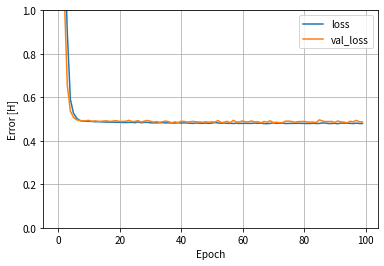

In [66]:
plot_loss(history)

In [67]:
test_results['rnn_Vmsat_model'] = rnn_Vmsat_model.evaluate(
    test_features['Vmsat'], test_labels,
    verbose=0)

In [68]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vmsat_model,0.493667
linear_model,0.477027
dnn_Vmsat_model,0.486456
dnn_model,0.403960
rnn_Vmsat_model,0.471664


### Multi-variable 

In [69]:
normalizer = preprocessing.Normalization(input_shape=[4,1], axis=None)
normalizer.adapt(np.array(train_features))

In [70]:
rnn_model = build_and_compile_model_RNN(normalizer)
rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 4, 1)              3         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [71]:
%%time
history = rnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
34/34 [==============================] - 4s 45ms/step - loss: 1.7895 - val_loss: 0.8375
Epoch 2/100
34/34 [==============================] - 1s 23ms/step - loss: 0.8225 - val_loss: 0.7803
Epoch 3/100
34/34 [==============================] - 1s 18ms/step - loss: 0.8032 - val_loss: 0.7897
Epoch 4/100
34/34 [==============================] - 1s 25ms/step - loss: 0.7822 - val_loss: 0.7806
Epoch 5/100
34/34 [==============================] - 1s 16ms/step - loss: 0.7816 - val_loss: 0.7796
Epoch 6/100
34/34 [==============================] - 0s 15ms/step - loss: 0.7951 - val_loss: 0.7810
Epoch 7/100
34/34 [==============================] - 0s 13ms/step - loss: 0.7736 - val_loss: 0.7794
Epoch 8/100
34/34 [==============================] - 1s 17ms/step - loss: 0.8189 - val_loss: 0.7794
Epoch 9/100
34/34 [==============================] - 1s 15ms/step - loss: 0.7898 - val_loss: 0.7801
Epoch 10/100
34/34 [==============================] - 0s 8ms/step - loss: 0.7780 - val_loss: 0.7793


34/34 [==============================] - 1s 24ms/step - loss: 0.7997 - val_loss: 0.7757
Epoch 83/100
34/34 [==============================] - 0s 8ms/step - loss: 0.8031 - val_loss: 0.7783
Epoch 84/100
34/34 [==============================] - 0s 14ms/step - loss: 0.7868 - val_loss: 0.7821
Epoch 85/100
34/34 [==============================] - 1s 18ms/step - loss: 0.7879 - val_loss: 0.7749
Epoch 86/100
34/34 [==============================] - 0s 14ms/step - loss: 0.7801 - val_loss: 0.7747
Epoch 87/100
34/34 [==============================] - 1s 18ms/step - loss: 0.7799 - val_loss: 0.7790
Epoch 88/100
34/34 [==============================] - 0s 15ms/step - loss: 0.7644 - val_loss: 0.7781
Epoch 89/100
34/34 [==============================] - 0s 11ms/step - loss: 0.7735 - val_loss: 0.7750
Epoch 90/100
34/34 [==============================] - 0s 14ms/step - loss: 0.8030 - val_loss: 0.7773
Epoch 91/100
34/34 [==============================] - 1s 16ms/step - loss: 0.7812 - val_loss: 0.7784
Epoc

In [72]:
test_results['rnn_model'] = rnn_model.evaluate(
    test_features, test_labels,
    verbose=0)

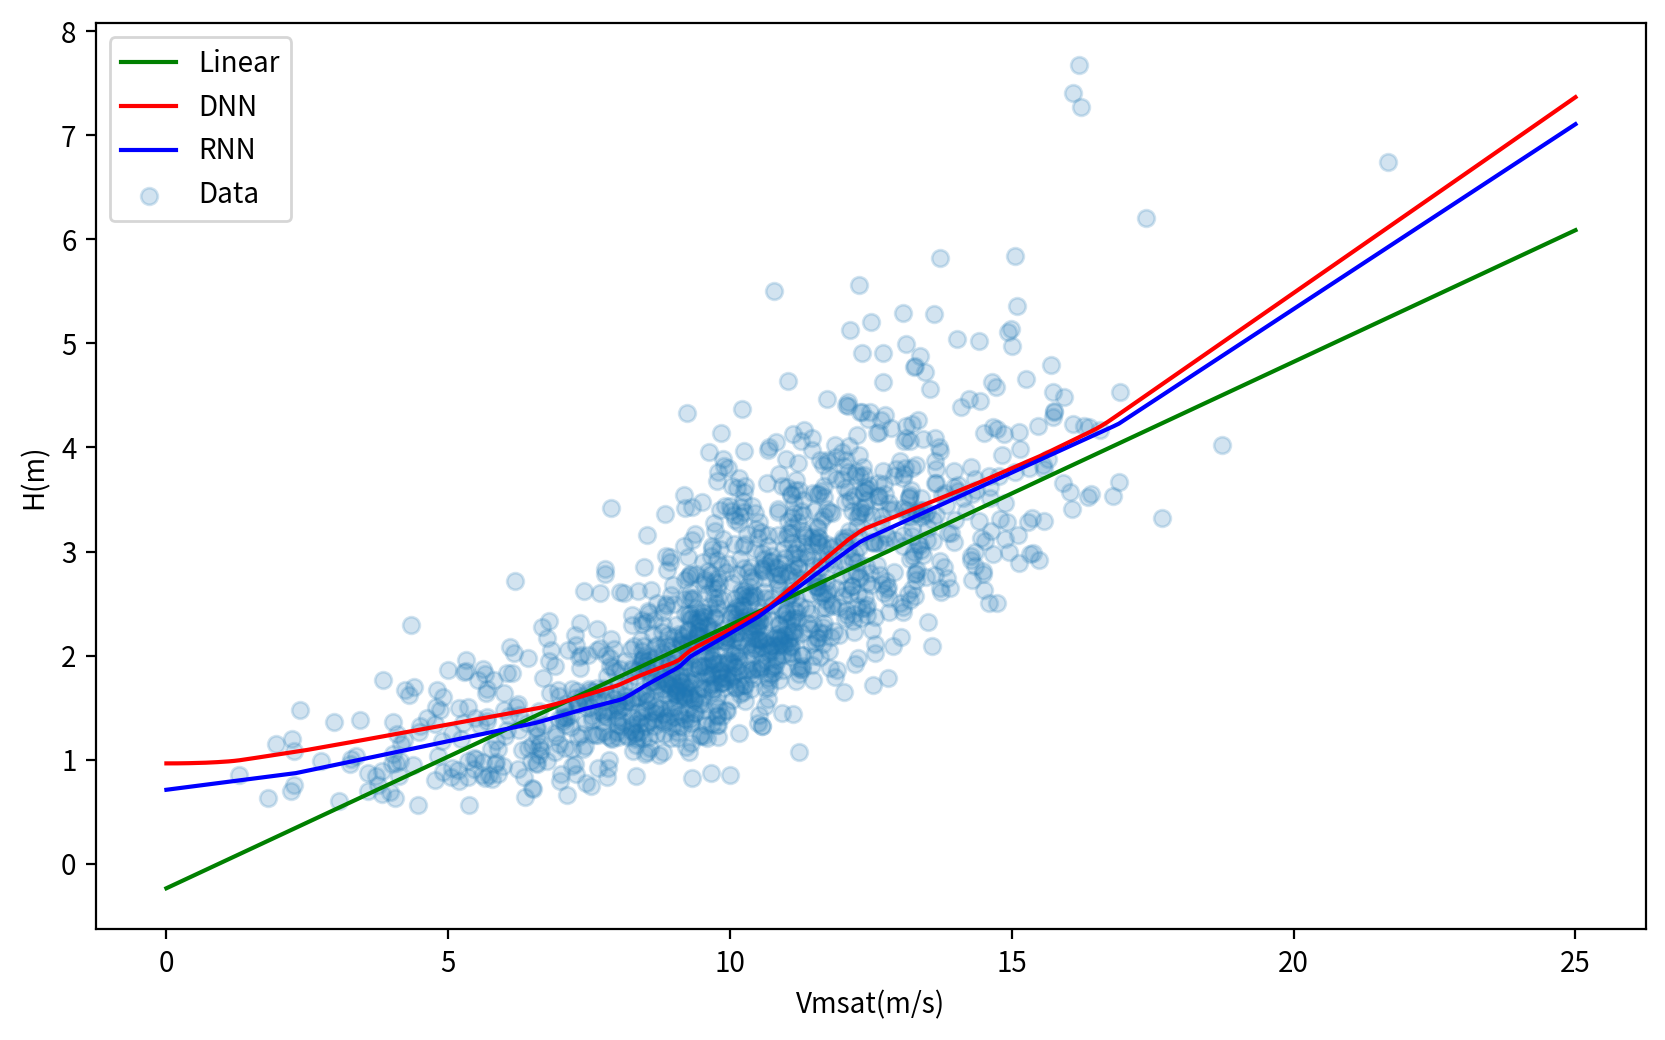

In [73]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
y1 = rnn_Vmsat_model.predict(x)
y2 = dnn_Vmsat_model.predict(x)
y4 = Vmsat_model.predict(x)

plt.scatter(train_features['Vmsat'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.plot(x, y1, color='b', label='RNN')
plt.xlabel('Vmsat(m/s)')
plt.ylabel('H(m)')
plt.legend()

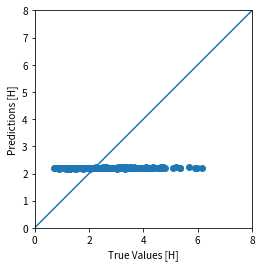

In [74]:
test_predictions = rnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

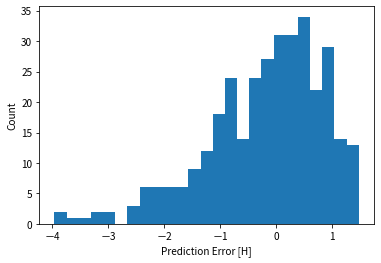

In [75]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

In [76]:
rnn_model.save(   'saved_model/Vmsat_H_rnn_model_DJF')
rnn_Vmsat_model.save('saved_model/Vmsat_H_rnn_Vm_model_DJF')

INFO:tensorflow:Assets written to: saved_model/Vmsat_H_rnn_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_H_rnn_Vm_model_DJF/assets


# SVM 

In [77]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [78]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [79]:
history = svr.fit(np.array(train_features['Vmsat']).reshape(-1,1), train_labels)

In [80]:
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    np.array(test_features['Vmsat']).reshape(-1,1),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

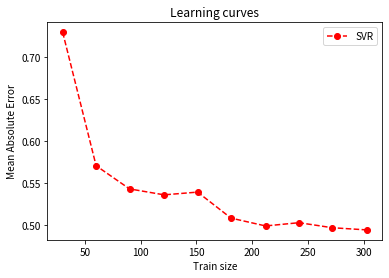

In [81]:
#plt.plot(train_sizes, -test_scores_kr.mean(1), "o--", color="g", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), "o--", color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning curves")
plt.legend(loc="best")

In [82]:
-test_scores_svr.mean(1)

array([0.73 , 0.571, 0.543, 0.536, 0.539, 0.508, 0.499, 0.503, 0.497,
       0.494])

In [83]:
svr.predict(np.array(train_features['Vmsat']).reshape(-1,1))

array([2.283, 3.797, 2.674, ..., 2.186, 2.757, 2.72 ])

### Save model

In [84]:
import joblib
joblib.dump(svr, 'saved_model/Vmsat_H_svr_Vm_model_DJF')

['saved_model/Vmsat_H_svr_Vm_model_DJF']

In [85]:
svr2 = joblib.load("saved_model/Vmsat_H_svr_Vm_model_DJF")

In [86]:
svr2.predict(np.array(train_features['Vmsat']).reshape(-1,1))

array([2.283, 3.797, 2.674, ..., 2.186, 2.757, 2.72 ])

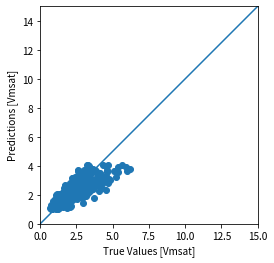

In [87]:
test_predictions = svr2.predict(np.asarray(test_features['Vmsat'])[:,None]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vmsat]')
plt.ylabel('Predictions [Vmsat]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

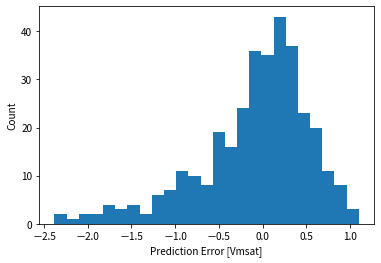

In [88]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vmsat]')
_ = plt.ylabel('Count')

## Multi-variable

In [89]:
history = svr.fit(np.array(train_features), train_labels)

In [90]:
train_sizes_mv, train_scores_svr_mv, test_scores_svr_mv = learning_curve(
    svr,
    np.array(test_features),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

### Save model

In [91]:
import joblib
joblib.dump(svr, 'saved_model/Vmsat_H_svr_model_DJF')

['saved_model/Vmsat_H_svr_model_DJF']

In [92]:
svr = joblib.load("saved_model/Vmsat_H_svr_model_DJF")

In [93]:
svr.predict(np.array(train_features))

array([2.151, 4.315, 2.78 , ..., 2.13 , 2.878, 2.51 ])

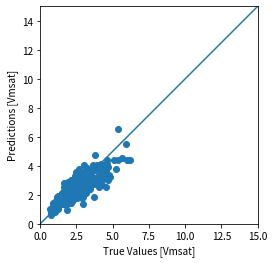

In [94]:
test_predictions = svr.predict(np.asarray(test_features)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vmsat]')
plt.ylabel('Predictions [Vmsat]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

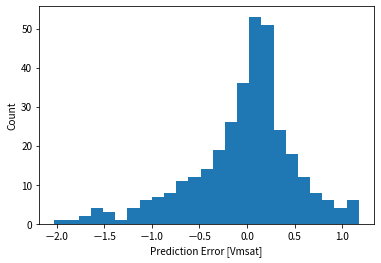

In [95]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vmsat]')
_ = plt.ylabel('Count')